In [1]:
pip install gymnasium numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import and smoke test

In [2]:
# Import 
import os, json, random
from collections import defaultdict, deque
from typing import Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from environment3 import LifeStyleEnv  # make sure this file is in the same folder

# quick smoke test (check environment)
env = LifeStyleEnv()
obs, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("Observation keys:", list(obs.keys()))
env.close()


Action space: Discrete(9)
Observation keys: ['current_weight_kg', 'current_bmi', 'current_stress_level', 'current_hunger_level', 'current_energy_level', 'daily_calories_burned', 'daily_calories_intake', 'daily_protein_intake', 'daily_fat_intake', 'daily_saturated_fat_intake', 'daily_carbs_intake', 'daily_fiber_intake', 'daily_calories_needed', 'current_timeslot', 'day_of_episode', 'time_since_last_meal', 'time_since_last_exercise']


# State Representation

In [3]:
# State Representation (binning helpers)
def _bin5(x: float, lo: float = 0.0, hi: float = 100.0) -> int:
    x = float(x)
    x = max(lo, min(hi, x))
    width = (hi - lo) / 5.0 if hi > lo else 1.0
    return min(4, int((x - lo) / width))

def _bin_bmi(bmi: float) -> int:
    b = float(bmi)
    if b < 16:  return 0
    if b < 18.5:return 1
    if b < 22:  return 2
    if b < 25:  return 3
    if b < 27:  return 4
    if b < 30:  return 5
    if b < 35:  return 6
    return 7  # >=35

def state_key(obs: Dict) -> Tuple[int, int, int, int, int]:
    bmi    = float(obs["current_bmi"][0])
    stress = float(obs["current_stress_level"][0])
    energy = float(obs["current_energy_level"][0])
    hunger = float(obs["current_hunger_level"][0])
    tslot  = int(obs["current_timeslot"])   # 0..23
    tbin   = tslot // 3                     # 8 bins (3h blocks)
    return (_bin_bmi(bmi), _bin5(stress), _bin5(energy), _bin5(hunger), tbin)

# Action mask getter
def get_valid_mask(env: LifeStyleEnv) -> np.ndarray:
    if hasattr(env, "action_masks"):
        m = env.action_masks()
    elif hasattr(env, "get_action_mask"):
        m = env.get_action_mask()
    else:
        m = np.ones(env.action_space.n, dtype=bool)

    if hasattr(env, "skip_count") and env.skip_count >= 3:  
        m[8] = False

    return m

# Q-table save/load
def save_q(Q: Dict[Tuple, float], path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    payload = {str(k): float(v) for k, v in Q.items()}
    with open(path, "w") as f:
        json.dump(payload, f)

def load_q(path: str) -> Dict[Tuple, float]:
    data = json.load(open(path))
    return {eval(k): v for k, v in data.items()}

# Action name mapping (for readability)
ACTION_NAME = {
    0: "meal: light", 1: "meal: medium", 2: "meal: heavy",
    3: "exercise: light", 4: "exercise: moderate", 5: "exercise: intense",
    6: "rest: light", 7: "rest: deep", 8: "skip",
}


# Random Baseline

In [4]:
def eval_random_masked(episodes=5, seed=123):
    scores = []
    for k in range(episodes):
        env = LifeStyleEnv()
        obs, info = env.reset(seed=seed+k)
        done, ep_ret = False, 0.0
        while not done:
            # use action mask if available
            mask = env.action_masks() if hasattr(env,"action_masks") else np.ones(env.action_space.n, dtype=bool)
            valid = np.where(mask)[0]
            a = int(np.random.choice(valid)) if len(valid) else 0
            obs, r, term, trunc, _ = env.step(a)
            ep_ret += float(r)
            done = bool(term or trunc)
        env.close()
        scores.append(ep_ret)
    return float(np.mean(scores)), float(np.std(scores))

# Run baseline
rand_mean, rand_std = eval_random_masked(episodes=5)
print(f"Random (mask-aware) baseline: mean={rand_mean:.2f} ± {rand_std:.2f}")


Random (mask-aware) baseline: mean=-3458.74 ± 1192.64


# Greedy evaluator

In [5]:
# Greedy Evaluation Function
def evaluate_greedy(Q: Dict[Tuple, float], episodes: int = 3, seed: int = 123) -> float:
    scores = []
    for k in range(episodes):
        env = LifeStyleEnv()
        obs, info = env.reset(seed=seed + k)
        s = state_key(obs); done = False; ep_ret = 0.0
        while not done:
            valid = get_valid_mask(env)
            idx = np.where(valid)[0]
            a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0
            obs2, r, term, trunc, info = env.step(a)
            s, ep_ret, done = state_key(obs2), ep_ret + float(r), bool(term or trunc)
        env.close()
        scores.append(ep_ret)
    return float(np.mean(scores))


# Exploration strategies & action picker

In [6]:
from enum import Enum

class Explore(Enum):
    EPS_DECAY = 1
    EPS_FIXED = 2
    SOFTMAX   = 3
    UCB       = 4

def pick_action_explore(
    Q: Dict[Tuple, float],
    s: Tuple[int, ...],
    env: LifeStyleEnv,
    valid_mask: np.ndarray,
    n_actions: int,
    ep_idx: int,
    *,
    strategy: Explore,
    eps: float,
    eps_end: float,
    eps_decay: float,
    tau: float,
    ucb_counts: dict,
    ucb_c: float,
    total_ucb_steps: int
) -> int:
    """Choose an action among valid ones according to the exploration strategy."""
    valid_idx = np.where(valid_mask)[0]
    if len(valid_idx) == 0:
        return int(np.random.randint(n_actions))

    # tiny preference for non-skip when Q ties
    def _pref_non_skip_score(state, a, Qtable):
        q = Qtable.get((state, int(a)), 0.0)
        tiny = 1e-9  # prefer non-skip (a != 8) when equal q
        return (q, 0.0 if int(a) == 8 else tiny)

    if strategy == Explore.EPS_DECAY:
        # epsilon supplied from caller; caller will decay it each episode
        if np.random.rand() < eps:
            return int(np.random.choice(valid_idx))
        # greedy among valid
        return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))

    if strategy == Explore.EPS_FIXED:
        # use eps_end as the fixed epsilon
        if np.random.rand() < eps_end:
            return int(np.random.choice(valid_idx))
        return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))

    if strategy == Explore.SOFTMAX:
        # Boltzmann/Softmax over Q-values on valid actions
        qvals = np.array([Q.get((s, int(a)), 0.0) for a in valid_idx], dtype=float)
        # numerical stability
        z = (qvals / max(tau, 1e-6))
        z = z - z.max()
        probs = np.exp(z)
        probs /= probs.sum() if probs.sum() > 0 else 1.0
        choice = int(np.random.choice(np.arange(len(valid_idx)), p=probs))
        return int(valid_idx[choice])

    if strategy == Explore.UCB:
        # Upper Confidence Bound: Q + c * sqrt( ln(t) / (N(s,a)+1) )
        t = max(total_ucb_steps, 1)
        best_a, best_score = None, -1e18
        for a in valid_idx:
            n_sa = ucb_counts.get((s, int(a)), 0)
            bonus = ucb_c * np.sqrt(np.log(t) / (n_sa + 1.0))
            score = Q.get((s, int(a)), 0.0) + bonus
            if score > best_score:
                best_score, best_a = score, int(a)
        return int(best_a)

    # default fallback: greedy among valid
    return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))


# Dyna-Q trainer

In [7]:
def train_dyna_q_explore(episodes: int = 250,
                         alpha: float = 0.10,
                         gamma: float = 0.99,
                         eps_start: float = 1.0,
                         eps_end: float = 0.05,
                         eps_decay: float = 0.995,
                         planning_steps: int = 12,
                         model_cap: int = 20000,
                         seed: int = 42,
                         eval_every: int = 20,
                         best_path: str = "saved_models/dyna_q_best.json",
                         strategy: Explore = Explore.EPS_DECAY,
                         tau: float = 1.0,
                         ucb_c: float = 1.4):
    """
    Dyna-Q with pluggable exploration strategies.
    """
    random.seed(seed); np.random.seed(seed)
    env = LifeStyleEnv()
    nA = env.action_space.n

    Q = defaultdict(float)
    model = {}                     # (s,a) -> (s', r)
    seen_pairs = deque(maxlen=model_cap)

    returns = []
    epsilon = eps_start
    best_eval = -float("inf")

    # UCB stats
    ucb_counts = {}
    total_steps = 0

    for ep in range(1, episodes + 1):
        obs, info = env.reset(seed=seed + ep)
        s = state_key(obs); done = False; ep_ret = 0.0

        while not done:
            valid = get_valid_mask(env)

            a = pick_action_explore(
                Q, s, env, valid, nA, ep,
                strategy=strategy,
                eps=epsilon,
                eps_end=eps_end,
                eps_decay=eps_decay,
                tau=tau,
                ucb_counts=ucb_counts,
                ucb_c=ucb_c,
                total_ucb_steps=total_steps + 1
            )

            obs2, r, terminated, truncated, info = env.step(int(a))
            s2 = state_key(obs2)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            total_steps += 1

            # UCB bookkeeping
            if strategy == Explore.UCB:
                ucb_counts[(s, int(a))] = ucb_counts.get((s, int(a)), 0) + 1

            # Real TD update (mask-aware on s')
            valid_next = get_valid_mask(env)
            idx_next = np.where(valid_next)[0]
            max_next = max((Q[(s2, int(a2))] for a2 in idx_next), default=0.0)

            Q[(s, a)] += alpha * (r + gamma * max_next - Q[(s, a)])

           # --- Store model with s' valid actions ---
            key = (s, a)
            model[key] = (s2, float(r), tuple(int(i) for i in idx_next))
            seen_pairs.append(key)

              # --- Planning updates (also mask-aware) ---
            for _ in range(planning_steps):
                sp, ap = random.choice(seen_pairs)
                sp2, rp, idx_next_model = model[(sp, ap)]
                if idx_next_model:
                    max_p = max(Q[(sp2, int(a2))] for a2 in idx_next_model)
                else:
                    max_p = 0.0
                Q[(sp, ap)] += alpha * (rp + gamma * max_p - Q[(sp, ap)])

            s = s2

        returns.append(ep_ret)

        # Epsilon schedule (only for EPS_DECAY)
        if strategy == Explore.EPS_DECAY:
            epsilon = max(eps_end, epsilon * eps_decay)

        if ep % eval_every == 0:
            score = evaluate_greedy(Q, episodes=3, seed=777)
            if score > best_eval:
                best_eval = score
                save_q(Q, best_path)
            avg10 = float(np.mean(returns[-min(10, len(returns)):] ))
            print(f"{strategy.name:>9} | ep {ep:04d} | last10={avg10:8.2f} | "
                  f"eval={score:8.2f} | best={best_eval:8.2f} | eps={epsilon:5.3f}")

    env.close()
    return Q, np.asarray(returns, dtype=float)


# Training Run (ε-decay default) & learning-curve plot

EPS_DECAY | ep 0020 | last10=-2132.40 | eval=  760.36 | best=  760.36 | eps=0.905
EPS_DECAY | ep 0040 | last10=-1220.49 | eval= 2807.18 | best= 2807.18 | eps=0.818
EPS_DECAY | ep 0060 | last10=  615.57 | eval= 3544.15 | best= 3544.15 | eps=0.740
EPS_DECAY | ep 0080 | last10= 1054.52 | eval= 3180.32 | best= 3544.15 | eps=0.670
EPS_DECAY | ep 0100 | last10=  937.87 | eval= 3727.75 | best= 3727.75 | eps=0.606
EPS_DECAY | ep 0120 | last10= 1565.83 | eval= 2837.55 | best= 3727.75 | eps=0.548
EPS_DECAY | ep 0140 | last10= 2248.42 | eval= 2251.60 | best= 3727.75 | eps=0.496
EPS_DECAY | ep 0160 | last10= 2126.33 | eval= -980.90 | best= 3727.75 | eps=0.448
EPS_DECAY | ep 0180 | last10= 2745.08 | eval= 4325.60 | best= 4325.60 | eps=0.406
EPS_DECAY | ep 0200 | last10= 2385.23 | eval=10409.77 | best=10409.77 | eps=0.367
EPS_DECAY | ep 0220 | last10= 2178.65 | eval= 3639.37 | best=10409.77 | eps=0.332
EPS_DECAY | ep 0240 | last10= 2761.34 | eval= 3130.73 | best=10409.77 | eps=0.300
✅ training finis

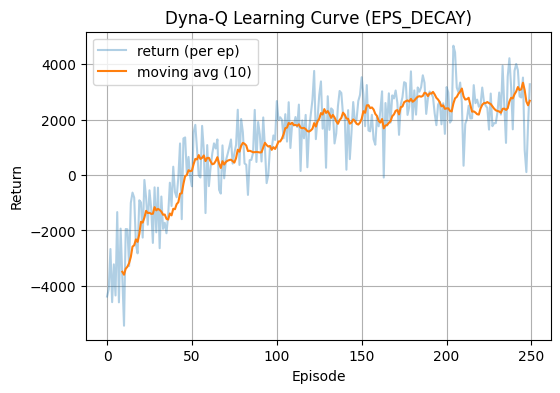

In [8]:
EPISODES = 250
PLANNING = 15
ALPHA = 0.10
EVAL_EVERY = 20

Q, returns = train_dyna_q_explore(
    episodes=EPISODES,
    planning_steps=PLANNING,
    alpha=ALPHA,
    eval_every=EVAL_EVERY,
    best_path="saved_models/dyna_q_best.json",
    strategy=Explore.EPS_DECAY
)
print("✅ training finished")

# Plot learning curve
plt.figure(figsize=(6,4))
win = 10
if len(returns) >= win:
    mov = np.convolve(returns, np.ones(win)/win, mode='valid')
    plt.plot(returns, alpha=0.35, label='return (per ep)')
    plt.plot(np.arange(win-1, win-1+len(mov)), mov, label=f'moving avg ({win})')
else:
    plt.plot(returns, label='return (per ep)')
plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Dyna-Q Learning Curve (EPS_DECAY)')
plt.legend(); plt.grid(True); plt.show()


 # Greedy Day-1 Plan & Metrics Visualization

Greedy Day-1 plan (hour → action)
00:00 → skip
01:00 → skip
02:00 → skip
03:00 → skip
04:00 → skip
05:00 → skip
06:00 → exercise: light
07:00 → rest: deep
08:00 → meal: light
09:00 → meal: light
10:00 → skip
11:00 → skip
12:00 → exercise: moderate
13:00 → skip
14:00 → skip
15:00 → skip
16:00 → skip
17:00 → skip
18:00 → meal: light
19:00 → rest: deep
20:00 → exercise: intense
21:00 → meal: light
22:00 → skip
23:00 → skip


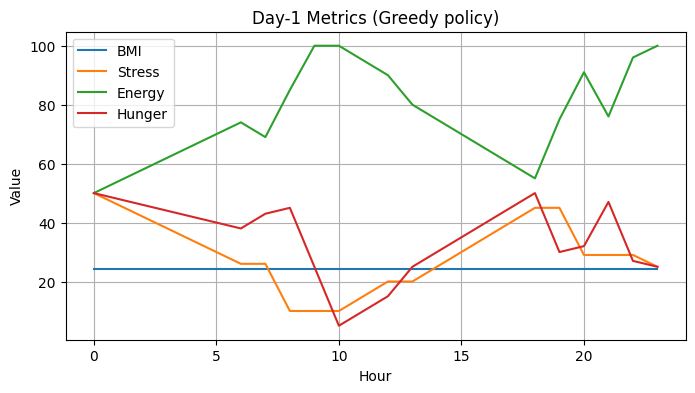

In [9]:
def greedy_day_plan(Q: Dict[Tuple, float], seed: int = 123):
    env = LifeStyleEnv()
    obs, info = env.reset(seed=seed)
    s = state_key(obs); done = False

    timeline: List[int] = []
    metrics = {"Hour": [], "BMI": [], "Stress": [], "Energy": [], "Hunger": []}

    while not done and len(timeline) < 24:  # first day only
        valid = get_valid_mask(env)
        idx = np.where(valid)[0]
        a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0

        # log before step
        metrics["Hour"].append(int(obs["current_timeslot"]))
        metrics["BMI"].append(float(obs["current_bmi"][0]))
        metrics["Stress"].append(float(obs["current_stress_level"][0]))
        metrics["Energy"].append(float(obs["current_energy_level"][0]))
        metrics["Hunger"].append(float(obs["current_hunger_level"][0]))
        timeline.append(a)

        obs2, r, term, trunc, info = env.step(a)
        s, obs, done = state_key(obs2), obs2, bool(term or trunc)
    env.close()
    return timeline, metrics

timeline, metrics = greedy_day_plan(Q, seed=321)

print("Greedy Day-1 plan (hour → action)")
for h, a in zip(metrics["Hour"], timeline):
    print(f"{h:02d}:00 → {ACTION_NAME[a]}")

plt.figure(figsize=(8,4))
for k in ["BMI","Stress","Energy","Hunger"]:
    plt.plot(metrics["Hour"], metrics[k], label=k)
plt.xlabel("Hour"); plt.ylabel("Value"); plt.title("Day-1 Metrics (Greedy policy)")
plt.legend(); plt.grid(True); plt.show()


# Save Q & quick baseline vs learned comparison

In [10]:
# Save the latest table
save_q(Q, "saved_models/dyna_q_table.json")
print("Saved final Q-table to saved_models/dyna_q_table.json")

# Random vs. Dyna-Q comparison
rand_mean, rand_std = eval_random_masked(episodes=10, seed=123)
dq_mean = evaluate_greedy(Q, episodes=10, seed=777)

print("=== Baseline vs Learned (Greedy) ===")
print(f"Random (mask-aware)   : mean = {rand_mean:.2f} ± {rand_std:.2f}")
print(f"Dyna-Q (greedy policy): mean = {dq_mean:.2f}")


Saved final Q-table to saved_models/dyna_q_table.json
=== Baseline vs Learned (Greedy) ===
Random (mask-aware)   : mean = -3242.46 ± 1267.47
Dyna-Q (greedy policy): mean = -4806.05


=== Return summary (higher is better unless your reward is penalty-style) ===
    Random: mean=-3403.80  std=1218.52  min=-5680.12  max=-1450.77
    Dyna-Q: mean=-4806.05  std=0.00  min=-4806.05  max=-4806.05
Δ mean (Dyna-Q − Random) = -1402.25


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7256\551283667.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rand_returns, dq_returns], labels=["Random","Dyna-Q"], showmeans=True)


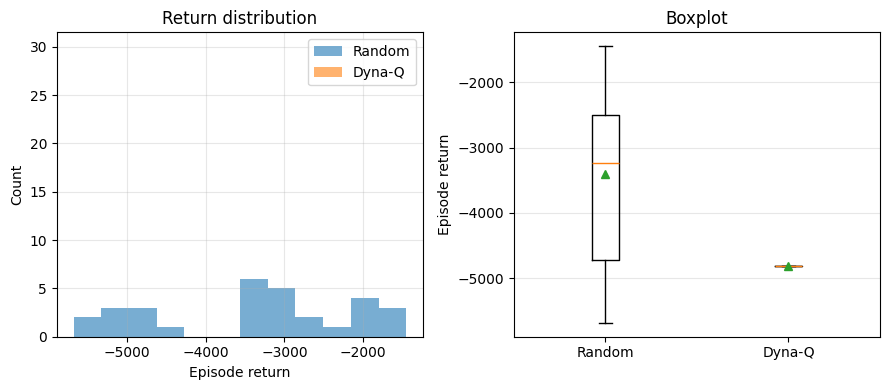

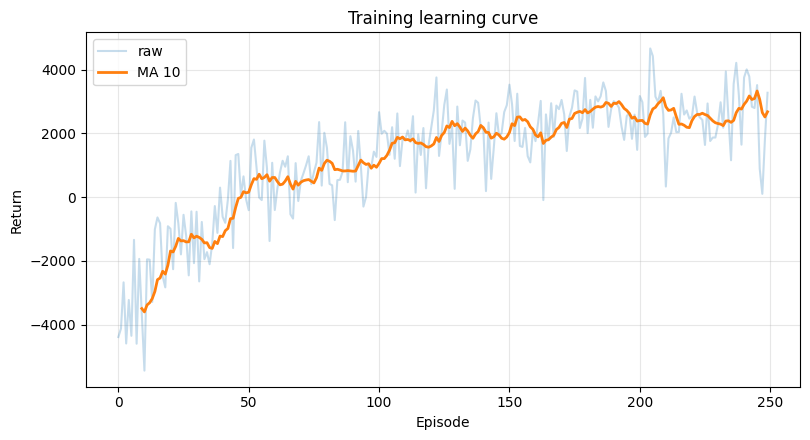


Note: returns are negative on average. If your reward is penalty-style (more negative = better),
then a lower mean is better. If your reward is standard (higher = better),
and Dyna-Q < Random, the agent underperformed and may need more episodes/tuning or bug fixes.


In [11]:
# ==== ANALYSIS: Random vs Dyna-Q (distributions + learning curve) ====
import numpy as np
import matplotlib.pyplot as plt

# --- helpers to collect episode returns ---
def _run_random(env_ctor, episodes=30, seed=1000):
    rets = []
    for k in range(episodes):
        env = env_ctor()
        obs, info = env.reset(seed=seed + k)
        done, ep_ret = False, 0.0
        while not done:
            mask = env.action_masks() if hasattr(env, "action_masks") else np.ones(env.action_space.n, dtype=bool)
            valid = np.where(mask)[0]
            a = int(np.random.choice(valid)) if len(valid) else 0
            obs, r, term, trunc, _ = env.step(a)
            ep_ret += float(r)
            done = bool(term or trunc)
        env.close()
        rets.append(ep_ret)
    return np.asarray(rets, dtype=float)

def _run_greedy(Q, env_ctor, episodes=30, seed=2000):
    rets = []
    for k in range(episodes):
        env = env_ctor()
        obs, info = env.reset(seed=seed + k)
        s = state_key(obs); done, ep_ret = False, 0.0
        while not done:
            mask = get_valid_mask(env)
            idx = np.where(mask)[0]
            a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0
            obs2, r, term, trunc, _ = env.step(a)
            ep_ret += float(r)
            s = state_key(obs2)
            done = bool(term or trunc)
        env.close()
        rets.append(ep_ret)
    return np.asarray(rets, dtype=float)

# --- run both policies ---
from environment3 import LifeStyleEnv  # adjust if your env module name differs

Q_to_use = Q_final if "Q_final" in globals() else (Q if "Q" in globals() else None)
if Q_to_use is None:
    raise RuntimeError("No Q table found (expected Q_final or Q). Train your agent first.")

rand_returns = _run_random(LifeStyleEnv, episodes=30, seed=123)
dq_returns   = _run_greedy(Q_to_use, LifeStyleEnv, episodes=30, seed=456)

# --- print stats ---
def _summ(name, arr):
    print(f"{name:>10}: mean={arr.mean():.2f}  std={arr.std():.2f}  min={arr.min():.2f}  max={arr.max():.2f}")

print("=== Return summary (higher is better unless your reward is penalty-style) ===")
_summ("Random", rand_returns)
_summ("Dyna-Q", dq_returns)
print(f"Δ mean (Dyna-Q − Random) = {dq_returns.mean() - rand_returns.mean():.2f}")

# --- distribution plots: histogram + boxplot ---
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.hist(rand_returns, bins=12, alpha=0.6, label="Random")
plt.hist(dq_returns,   bins=12, alpha=0.6, label="Dyna-Q")
plt.xlabel("Episode return"); plt.ylabel("Count"); plt.title("Return distribution")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.boxplot([rand_returns, dq_returns], labels=["Random","Dyna-Q"], showmeans=True)
plt.ylabel("Episode return"); plt.title("Boxplot")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

# --- show training learning curve if available ---
if "rets_final" in globals():
    arr = np.asarray(rets_final, dtype=float)
elif "returns" in globals():
    arr = np.asarray(returns, dtype=float)
else:
    arr = None

if arr is not None and len(arr) > 0:
    w = 10
    plt.figure(figsize=(8.2,4.5))
    plt.plot(arr, alpha=0.25, label="raw")
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode="valid")
        plt.plot(np.arange(w-1, w-1+len(mov)), mov, linewidth=2, label=f"MA {w}")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Training learning curve")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No training returns array found (rets_final/returns).")

# --- quick note about reward sign ---
if rand_returns.mean() < 0 or dq_returns.mean() < 0:
    print("\nNote: returns are negative on average. If your reward is penalty-style (more negative = better),")
    print("then a lower mean is better. If your reward is standard (higher = better),")
    print("and Dyna-Q < Random, the agent underperformed and may need more episodes/tuning or bug fixes.")


#  Exploration strategies (ε-decay, Softmax, UCB) + overlay plot + table

In [12]:
# Train three strategies
Q_eps, rets_eps = train_dyna_q_explore(strategy=Explore.EPS_DECAY, episodes=180, planning_steps=15, alpha=0.10,
                                       best_path="saved_models/q_eps.json")
Q_smx, rets_smx = train_dyna_q_explore(strategy=Explore.SOFTMAX,   episodes=180, planning_steps=15, alpha=0.10, tau=0.8,
                                       best_path="saved_models/q_softmax.json")
Q_ucb, rets_ucb = train_dyna_q_explore(strategy=Explore.UCB,       episodes=180, planning_steps=15, alpha=0.10, ucb_c=1.4,
                                       best_path="saved_models/q_ucb.json")


# Evaluate each strategy (greedy) for fair comparison
eps_eval = evaluate_greedy(Q_eps, episodes=10, seed=777)
smx_eval = evaluate_greedy(Q_smx, episodes=10, seed=777)
ucb_eval = evaluate_greedy(Q_ucb, episodes=10, seed=777)

print("=== Final Evaluation (10 episodes, greedy) ===")
print(f"EPS_DECAY         : {eps_eval:.2f}")
print(f"SOFTMAX (τ=0.8)   : {smx_eval:.2f}")
print(f"UCB (c=1.4)       : {ucb_eval:.2f}")


EPS_DECAY | ep 0020 | last10=-2132.40 | eval=  760.36 | best=  760.36 | eps=0.905
EPS_DECAY | ep 0040 | last10=-1220.49 | eval= 2807.18 | best= 2807.18 | eps=0.818
EPS_DECAY | ep 0060 | last10=  615.57 | eval= 3544.15 | best= 3544.15 | eps=0.740
EPS_DECAY | ep 0080 | last10= 1054.52 | eval= 3180.32 | best= 3544.15 | eps=0.670
EPS_DECAY | ep 0100 | last10=  937.87 | eval= 3727.75 | best= 3727.75 | eps=0.606
EPS_DECAY | ep 0120 | last10= 1565.83 | eval= 2837.55 | best= 3727.75 | eps=0.548
EPS_DECAY | ep 0140 | last10= 2248.42 | eval= 2251.60 | best= 3727.75 | eps=0.496
EPS_DECAY | ep 0160 | last10= 2126.33 | eval= -980.90 | best= 3727.75 | eps=0.448
EPS_DECAY | ep 0180 | last10= 2745.08 | eval= 4325.60 | best= 4325.60 | eps=0.406
  SOFTMAX | ep 0020 | last10=  538.98 | eval= 5603.52 | best= 5603.52 | eps=1.000
  SOFTMAX | ep 0040 | last10= 3842.90 | eval= 3452.02 | best= 5603.52 | eps=1.000
  SOFTMAX | ep 0060 | last10= 4191.03 | eval= 5018.59 | best= 5603.52 | eps=1.000
  SOFTMAX | ep 0

# Results Summary (Exploration Comparison)

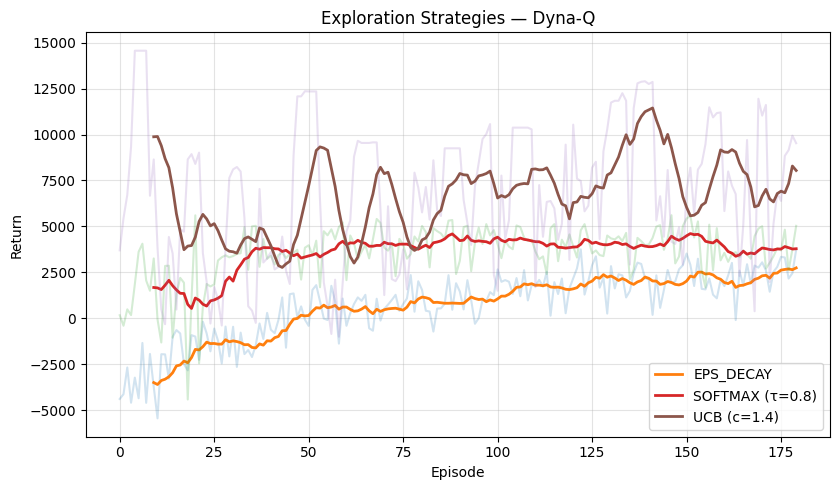

Saved: figs/step5_exploration_learning_curves.png


In [13]:
#  Overlay learning curves and save
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.5,5))
plot_with_ma(rets_eps, "EPS_DECAY")
plot_with_ma(rets_smx, "SOFTMAX (τ=0.8)")
plot_with_ma(rets_ucb, "UCB (c=1.4)")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Exploration Strategies — Dyna-Q")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.savefig("figs/step5_exploration_learning_curves.png", dpi=180)
plt.show()

print("Saved:", "figs/step5_exploration_learning_curves.png")


# Pick the winner automatically and save its Q-table

In [14]:
# Declare winner & save best Q-table
scores = {
    "EPS_DECAY": float(eps_eval),
    "SOFTMAX":   float(smx_eval),
    "UCB":       float(ucb_eval),
}
winner = max(scores, key=scores.get)

q_lookup = {
    "EPS_DECAY": Q_eps,
    "SOFTMAX":   Q_smx,
    "UCB":       Q_ucb,
}

best_Q = q_lookup[winner]

os.makedirs("saved_models", exist_ok=True)
best_path = f"saved_models/dyna_q_best_{winner.lower()}.json"
save_q(best_Q, best_path)

print(f"🏆 Best strategy: {winner}  (mean return = {scores[winner]:.2f})")
print("Best Q-table saved to:", best_path)


🏆 Best strategy: UCB  (mean return = 9468.21)
Best Q-table saved to: saved_models/dyna_q_best_ucb.json


# Step 6: Fine-Tuning & Hyperparameter Sweeps

In [15]:
# Helpers: run a training with fixed settings, then evaluate ===
from statistics import mean

def run_once(strategy,
             episodes=180,
             alpha=0.10,
             gamma=0.99,
             planning_steps=15,
             ucb_c=1.4,
             tau=0.8,
             seed=1234,
             best_path="saved_models/tmp.json"):
    Q, rets = train_dyna_q_explore(
        episodes=episodes,
        alpha=alpha,
        gamma=gamma,
        planning_steps=planning_steps,
        strategy=strategy,
        ucb_c=ucb_c,
        tau=tau,
        best_path=best_path,
        eval_every=99999,         # silence mid-prints
        seed=seed,
    )
    eval_score = evaluate_greedy(Q, episodes=10, seed=777)
    last10 = float(mean(rets[-10:])) if len(rets) >= 10 else float(mean(rets))
    return Q, rets, eval_score, last10

def print_table(rows, headers=("Setting","Eval","Last10Avg")):
    # rows: list of tuples like (label, eval, last10)
    w = [max(len(str(h)), max(len(str(r[i])) for r in rows)) for i,h in enumerate(headers)]
    fmt = " | ".join(f"{{:{ww}}}" for ww in w)
    print(fmt.format(*headers))
    print("-+-".join("-"*ww for ww in w))
    for r in rows:
        print(fmt.format(*r))


#  Part 1 : UCB coefficient sweep (c)

In [16]:
C_LIST = [0.8, 1.0, 1.2, 1.4, 1.6, 2.0]

EPISODES_FT   = 180    
PLANNING_FT   = 15
ALPHA_FT      = 0.10
EVAL_EVERY_FT = 20

ucb_runs = []   # will store (c, Q, returns, eval_score)
for c in C_LIST:
    print(f"\n=== Tuning UCB: c={c} ===")
    Q_c, rets_c = train_dyna_q_explore(
        strategy=Explore.UCB,
        ucb_c=c,
        episodes=EPISODES_FT,
        planning_steps=PLANNING_FT,
        alpha=ALPHA_FT,
        eval_every=EVAL_EVERY_FT,
        best_path=f"saved_models/ucb_c_{c:.2f}.json"
    )
    score_c = evaluate_greedy(Q_c, episodes=10, seed=777)
    print(f"[UCB c={c}] final greedy eval = {score_c:.2f}")
    ucb_runs.append((c, Q_c, rets_c, score_c))


=== Tuning UCB: c=0.8 ===
      UCB | ep 0020 | last10= 5165.09 | eval= 3212.83 | best= 3212.83 | eps=1.000
      UCB | ep 0040 | last10= 2934.89 | eval= 4340.82 | best= 4340.82 | eps=1.000
      UCB | ep 0060 | last10= 8026.92 | eval=  957.62 | best= 4340.82 | eps=1.000
      UCB | ep 0080 | last10= 1893.93 | eval= 5164.57 | best= 5164.57 | eps=1.000
      UCB | ep 0100 | last10= 5814.11 | eval= 3960.75 | best= 5164.57 | eps=1.000
      UCB | ep 0120 | last10= 4303.27 | eval= 4526.90 | best= 5164.57 | eps=1.000
      UCB | ep 0140 | last10= 6532.26 | eval= 9734.13 | best= 9734.13 | eps=1.000
      UCB | ep 0160 | last10= 6084.93 | eval= 5566.52 | best= 9734.13 | eps=1.000
      UCB | ep 0180 | last10= 5983.61 | eval= 5935.36 | best= 9734.13 | eps=1.000
[UCB c=0.8] final greedy eval = 5935.36

=== Tuning UCB: c=1.0 ===
      UCB | ep 0020 | last10= 6032.36 | eval= 3681.08 | best= 3681.08 | eps=1.000
      UCB | ep 0040 | last10= 6221.90 | eval= 3878.59 | best= 3878.59 | eps=1.000
    

# Overlay learning curves for different c values

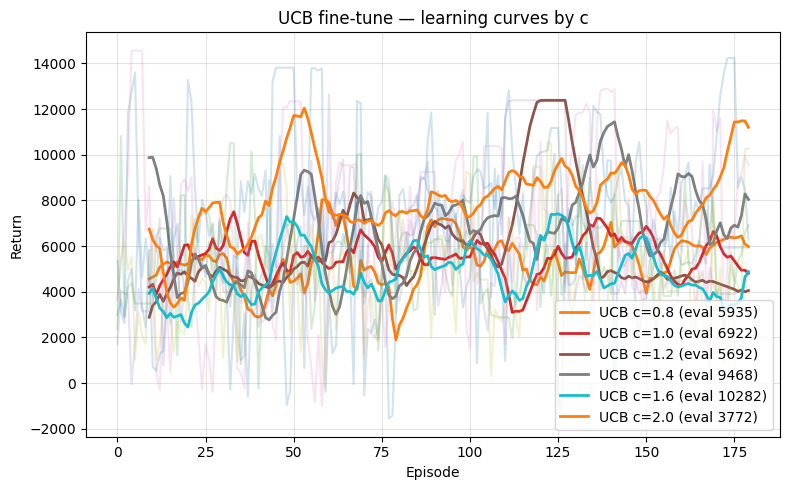

Saved figure to figs/ucb_finetune.png


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.makedirs("figs", exist_ok=True)

def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.0, 5.0))
for c, Q_c, rets_c, score_c in ucb_runs:
    plot_with_ma(rets_c, f"UCB c={c} (eval {score_c:.0f})")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("UCB fine-tune — learning curves by c")
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout()
plt.savefig("figs/ucb_finetune_curves.png", dpi=180)
plt.show()

print("Saved figure to figs/ucb_finetune.png")


# Select best c, save model, print table

In [18]:
# --- UCB fine-tune summary (table + save best) ---

import os, csv
import numpy as np

# Pick the best c by highest greedy evaluation score (x[3])
best_c, best_Q, best_rets, best_score = max(ucb_runs, key=lambda x: x[3])

# Build rows sorted by c for a nice table
rows = []
for c, Q_c, rets_c, score_c in sorted(ucb_runs, key=lambda x: x[0]):
    last10 = float(np.mean(rets_c[-10:])) if len(rets_c) >= 10 else float(np.mean(rets_c))
    rows.append([c, score_c, last10])

# Sort by c value
rows.sort(key=lambda x: x[0])

# Pretty print the table
print("\n" + "="*55)
print("UCB Fine-tune Summary (greedy eval over 10 episodes)")
print("="*55)

# Print header with proper spacing
print(f"|{'Value (c)':^10} | {'Eval Score':^12} | {'Last10 Avg':^12}|")
print("-" * 42)

# Print rows with proper formatting (thousands separators and alignment)
for c, score, last10 in rows:
    print(f"|{c:^10.1f} | {score:>12,.2f} | {last10:>12,.2f}|")

print("="*42)

# Highlight the best performer
print(f"\n✅ Best c = {best_c:.1f} with eval = {best_score:,.2f}")

# Save the best Q-table with a clear filename
os.makedirs("saved_models", exist_ok=True)
save_q(best_Q, f"saved_models/dyna_q_ucb_best_c_{best_c:.2f}.json")
print(f"Saved best UCB model to saved_models/dyna_q_ucb_best_c_{best_c:.2f}.json")

# Save the table as CSV and Markdown
os.makedirs("figs", exist_ok=True)

# CSV with raw values
with open("figs/ucb_finetune_table.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["Value_c", "Eval_Score", "Last10_Avg"])
    for row in rows:
        w.writerow(row)

# Markdown table with proper formatting
md_header = "| Value (c) | Eval Score | Last10 Avg |\n"
md_separator = "|:---------:|:----------:|:-----------:|\n"
md_rows = []
for c, score, last10 in rows:
    md_rows.append(f"| {c:.1f} | {score:,.2f} | {last10:,.2f} |")

with open("figs/ucb_finetune_table.md", "w") as f:
    f.write(md_header + md_separator + "\n".join(md_rows))

print("Saved table to figs/ucb_finetune_table.csv and figs/ucb_finetune_table.md")


UCB Fine-tune Summary (greedy eval over 10 episodes)
|Value (c)  |  Eval Score  |  Last10 Avg |
------------------------------------------
|   0.8     |     5,935.36 |     5,983.61|
|   1.0     |     6,922.06 |     4,812.21|
|   1.2     |     5,691.97 |     4,054.13|
|   1.4     |     9,468.21 |     8,043.30|
|   1.6     |    10,281.86 |     4,882.67|
|   2.0     |     3,772.07 |    11,201.06|

✅ Best c = 1.6 with eval = 10,281.86
Saved best UCB model to saved_models/dyna_q_ucb_best_c_1.60.json
Saved table to figs/ucb_finetune_table.csv and figs/ucb_finetune_table.md


# Part 2 : Tune learning rate alpha (using the best UCB c ) 

Alpha sweep (UCB, c=1.60)
| alpha   |  Eval Score  |  Last10 Avg |
----------------------------------------
|  0.05   |     5,243.36 |     5,243.62|
|  0.10   |     5,048.34 |     5,109.62|
|  0.20   |     5,273.87 |     3,577.24|
|  0.30   |     5,240.50 |     5,240.44|

✅ Best alpha = 0.20 (eval = 5273.87)
Saved: saved_models/dyna_q_ucb_best_alpha_0.20_c_1.60.json


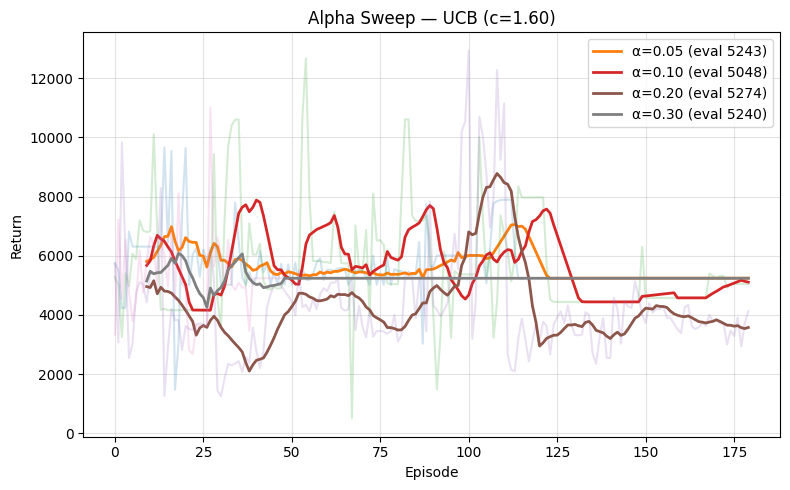

Saved figure: figs/alpha_sweep_curves.png


In [19]:
UCB_C  = float(best_c)   
EPIS   = 180
alphas = [0.05, 0.10, 0.20, 0.30]

alpha_runs = []
rows = []
for a in alphas:
    Qa, retsa, eval_a, last10_a = run_once(
        strategy=Explore.UCB,
        episodes=EPIS,
        alpha=a,
        gamma=0.9,
        planning_steps=15,
        ucb_c=UCB_C,
        seed=4242,
        best_path=f"saved_models/alpha_{a:.2f}_ucb{UCB_C:.2f}.json"
    )
    alpha_runs.append((a, Qa, retsa, eval_a, last10_a))
    rows.append((f"{a:.2f}", f"{eval_a:.2f}", f"{last10_a:.2f}"))

print(f"Alpha sweep (UCB, c={UCB_C:.2f})")
print("="*40)
print(f"|{'alpha':^8} | {'Eval Score':^12} | {'Last10 Avg':^12}|")
print("-"*40)
for a, Qa, retsa, eval_a, last10_a in sorted(alpha_runs, key=lambda x: x[0]):
    print(f"|{a:^8.2f} | {eval_a:>12,.2f} | {last10_a:>12,.2f}|")
print("="*40)

# Pick best by greedy eval and save it
best_a, bestQ_a, bestrets_a, besteval_a, _ = max(alpha_runs, key=lambda x: x[3])
print(f"\n✅ Best alpha = {best_a:.2f} (eval = {besteval_a:.2f})")
save_q(bestQ_a, f"saved_models/dyna_q_ucb_best_alpha_{best_a:.2f}_c_{UCB_C:.2f}.json")
print(f"Saved: saved_models/dyna_q_ucb_best_alpha_{best_a:.2f}_c_{UCB_C:.2f}.json")

# ---- Learning-curve overlay for the alpha sweep ----
import os, numpy as np, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)

def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    """Plot raw curve + moving average for readability."""
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode="valid")
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.0, 5.0))
for a, Qa, retsa, eval_a, _ in sorted(alpha_runs, key=lambda x: x[0]):
    plot_with_ma(retsa, f"α={a:.2f} (eval {eval_a:.0f})")

plt.xlabel("Episode")
plt.ylabel("Return")
plt.title(f"Alpha Sweep — UCB (c={UCB_C:.2f})")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.savefig("figs/alpha_sweep_curves.png", dpi=180)
plt.show()

print("Saved figure:", "figs/alpha_sweep_curves.png")

# Part 3 : Sweep planning_steps (using UCB with best c and alpha)

Planning sweep (UCB, c=1.60, alpha=0.20)
| planning  |  Eval Score  |  Last10 Avg |
-------------------------------------------
|    1      |     4,375.14 |     4,375.37|
|    3      |     2,811.51 |     2,811.34|
|    5      |     4,597.12 |     4,597.95|
|    10     |     4,588.99 |     4,721.01|
|    15     |     5,273.87 |     3,577.24|
|    20     |     6,366.81 |     5,173.74|
|    30     |     4,001.25 |     3,786.28|

✅ Best planning_steps = 20 (eval = 6366.81)


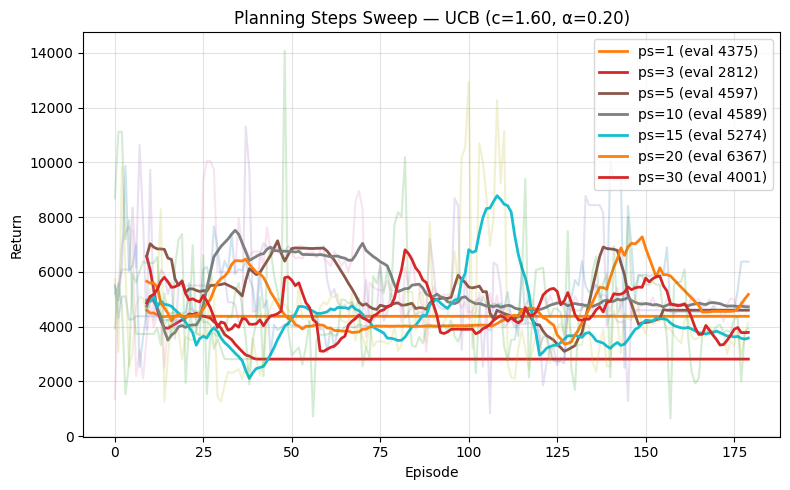

In [20]:
from statistics import mean
import numpy as np, os

# fallbacks if not defined
UCB_C   = float(locals().get("best_c", 1.4))
BEST_A  = float(locals().get("best_a", 0.10))
EPIS_PS = 180

plan_list = [1, 3, 5, 10, 15, 20, 30]
ps_runs, ps_rows = [], []

for ps in plan_list:
    Qps, rets_ps, eval_ps, last10_ps = run_once(
        strategy=Explore.UCB,
        episodes=EPIS_PS,
        alpha=BEST_A,
        gamma=0.9,
        planning_steps=ps,
        ucb_c=UCB_C,
        seed=4242,
        best_path=f"saved_models/ucb_c{UCB_C:.2f}_a{BEST_A:.2f}_ps{ps}.json"
    )
    ps_runs.append((ps, Qps, rets_ps, eval_ps, last10_ps))
    ps_rows.append((f"{ps}", f"{eval_ps:.2f}", f"{last10_ps:.2f}"))

# pretty table
print(f"Planning sweep (UCB, c={UCB_C:.2f}, alpha={BEST_A:.2f})")
print("="*43)
print(f"|{'planning':^10} | {'Eval Score':^12} | {'Last10 Avg':^12}|")
print("-"*43)
for ps, Qps, rets_ps, eval_ps, last10_ps in sorted(ps_runs, key=lambda x: x[0]):
    print(f"|{ps:^10d} | {eval_ps:>12,.2f} | {last10_ps:>12,.2f}|")
print("="*43)

# pick & save best by eval
best_ps, bestQ_ps, bestrets_ps, besteval_ps, _ = max(ps_runs, key=lambda x: x[3])
print(f"\n✅ Best planning_steps = {best_ps} (eval = {besteval_ps:.2f})")
save_q(bestQ_ps, f"saved_models/dyna_q_ucb_best_ps_{best_ps}_c_{UCB_C:.2f}_a_{BEST_A:.2f}.json")

# plot overlay
os.makedirs("figs", exist_ok=True)
import matplotlib.pyplot as plt
def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.0,5.0))
for ps, Qps, rets_ps, eval_ps, _ in ps_runs:
    plot_with_ma(rets_ps, f"ps={ps} (eval {eval_ps:.0f})")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title(f"Planning Steps Sweep — UCB (c={UCB_C:.2f}, α={BEST_A:.2f})")
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout(); plt.savefig("figs/planning_sweep.png", dpi=180)
plt.show()


# Part 4: γ sweep 


Gamma sweep (UCB)
| gamma   |  Eval Score  |  Last10 Avg |
-----------------------------------------
| 0.900   |     6,366.81 |     5,173.74|
| 0.950   |     2,966.58 |     7,916.55|
| 0.990   |     3,975.29 |     5,154.39|
| 0.995   |     8,796.67 |     3,123.75|
| 0.999   |     3,318.41 |     3,318.43|
✅ Best gamma = 0.995 (eval = 8796.67)


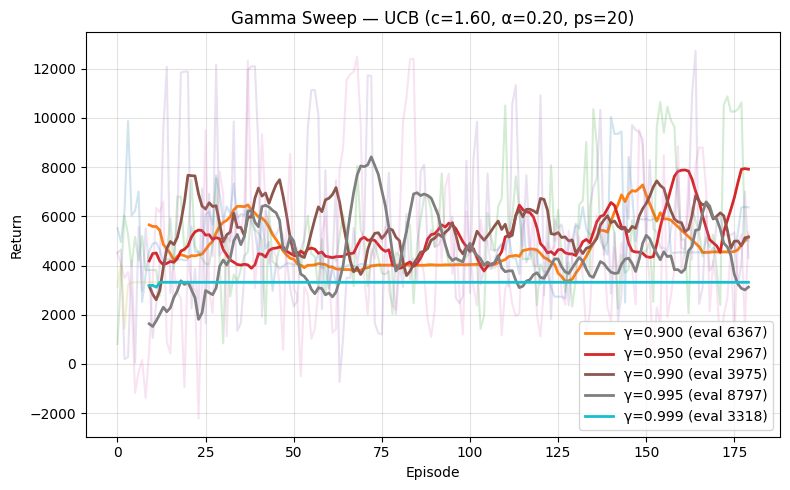

In [ ]:
# --- Gamma sweep with best (c, alpha, planning_steps) ---
BEST_C = float(best_c)          # from UCB sweep
BEST_A = float(best_a)          # from alpha sweep
BEST_PS = int(best_ps)          # from planning sweep
GAMMAS = [0.90, 0.95, 0.99, 0.995, 0.999]
EPIS = 180

gamma_runs = []
for g in GAMMAS:
    Qg, retsg, eval_g, last10_g = run_once(
        strategy=Explore.UCB,
        episodes=EPIS,
        alpha=BEST_A,
        gamma=g,
        planning_steps=BEST_PS,
        ucb_c=BEST_C,
        seed=4242,
        best_path=f"saved_models/gamma_{g:.3f}_ucb{BEST_C:.2f}_a{BEST_A:.2f}_ps{BEST_PS}.json"
    )
    gamma_runs.append((g, Qg, retsg, eval_g, last10_g))

# table
print("\nGamma sweep (UCB)")
print("="*41)
print(f"|{'gamma':^8} | {'Eval Score':^12} | {'Last10 Avg':^12}|")
print("-"*41)
for g, Qg, retsg, eval_g, last10_g in sorted(gamma_runs, key=lambda x: x[0]):
    print(f"|{g:^8.3f} | {eval_g:>12,.2f} | {last10_g:>12,.2f}|")
print("="*41)

# pick & save best
best_g, bestQ_g, bestrets_g, besteval_g, _ = max(gamma_runs, key=lambda x: x[3])
print(f"✅ Best gamma = {best_g:.3f} (eval = {besteval_g:.2f})")
save_q(bestQ_g, f"saved_models/dyna_q_ucb_best_gamma_{best_g:.3f}.json")

# curves
import os, numpy as np, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)
def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.0,5.0))
for g, Qg, retsg, eval_g, _ in sorted(gamma_runs, key=lambda x: x[0]):
    plot_with_ma(retsg, f"γ={g:.3f} (eval {eval_g:.0f})")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title(f"Gamma Sweep — UCB (c={BEST_C:.2f}, α={BEST_A:.2f}, ps={BEST_PS})")
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout(); plt.savefig("figs/gamma_sweep_curves.png", dpi=180)
plt.show()


# Multi-seed robustness check

In [22]:
# --- Multi-seed greedy evaluation for stability ---
SEEDS = range(20) 
scores = []
for s in SEEDS:
    score = evaluate_greedy(bestQ_g, episodes=1, seed=1000 + s)  # use final best Q
    scores.append(score)
print(f"Robustness (mean ± std over {len(SEEDS)} seeds): "
      f"{np.mean(scores):.2f} ± {np.std(scores):.2f}")


Robustness (mean ± std over 20 seeds): 8796.67 ± 0.00


# Ablation: Effect of Planning Steps on Dyna-Q (UCB)

Planning sweep (UCB, c=1.60, α=0.20, γ=0.995)
| planning  |   Eval Score   |   Last10 Avg  |
---------------------------------------------
|    0      |       6,591.08 |       6,591.58|
|    1      |       4,953.34 |       4,705.65|
|    3      |       4,844.81 |       4,845.04|
|    5      |       2,876.16 |       2,544.62|
|    10     |       1,911.43 |       5,653.18|
|    15     |       4,865.40 |       6,017.60|

✅ Best planning_steps = 0 (eval = 6591.08)


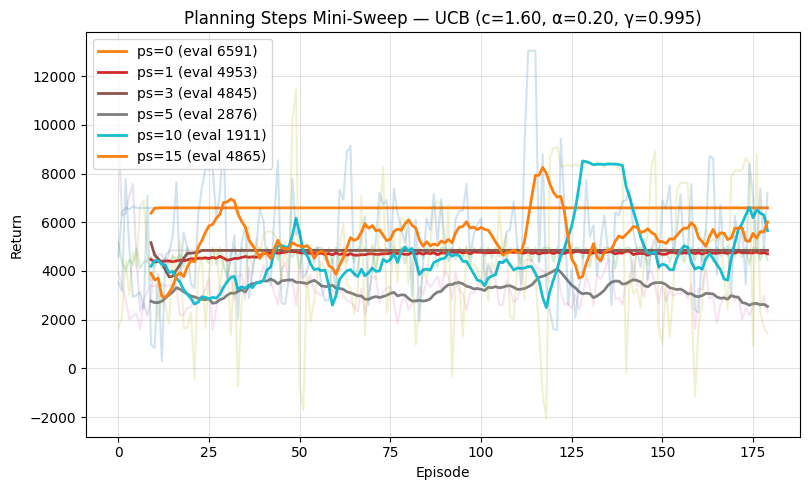

Saved figure: figs/planning_mini_sweep.png


In [28]:
import os, numpy as np, matplotlib.pyplot as plt

# Use best-tuned values if they exist; otherwise fall back to reasonable defaults
BEST_C  = float(locals().get("best_c", 2.0))     # from UCB sweep
BEST_A  = float(locals().get("best_a", 0.20))    # from alpha sweep
BEST_G  = float(locals().get("best_g", 0.99))    # from gamma sweep (or default)
EPIS_PS = 180

ps_list = [0, 1, 3, 5, 10,15]
ps_runs, ps_rows = [], []

for ps in ps_list:
    Qps, rets_ps, eval_ps, last10_ps = run_once(
        strategy=Explore.UCB,
        episodes=EPIS_PS,
        alpha=BEST_A,
        gamma=BEST_G,
        planning_steps=ps,
        ucb_c=BEST_C,
        seed=4242,
        best_path=f"saved_models/ucb_c{BEST_C:.2f}_a{BEST_A:.2f}_g{BEST_G:.3f}_ps{ps}.json"
    )
    ps_runs.append((ps, Qps, rets_ps, eval_ps, last10_ps))
    ps_rows.append((f"{ps}", f"{eval_ps:.2f}", f"{last10_ps:.2f}"))

# Pretty table
print(f"Planning sweep (UCB, c={BEST_C:.2f}, α={BEST_A:.2f}, γ={BEST_G:.3f})")
print("="*45)
print(f"|{'planning':^10} | {'Eval Score':^14} | {'Last10 Avg':^14}|")
print("-"*45)
for ps, Qps, rets_ps, eval_ps, last10_ps in sorted(ps_runs, key=lambda x: x[0]):
    print(f"|{ps:^10d} | {eval_ps:>14,.2f} | {last10_ps:>14,.2f}|")
print("="*45)

# Pick & save best by greedy eval
best_ps, bestQ_ps, bestrets_ps, besteval_ps, _ = max(ps_runs, key=lambda x: x[3])
print(f"\n✅ Best planning_steps = {best_ps} (eval = {besteval_ps:.2f})")
os.makedirs("saved_models", exist_ok=True)
save_q(bestQ_ps, f"saved_models/dyna_q_ucb_best_ps_{best_ps}_c_{BEST_C:.2f}_a_{BEST_A:.2f}_g_{BEST_G:.3f}.json")

# Learning-curve overlay
os.makedirs("figs", exist_ok=True)

def plot_with_ma(arr, label, w=10, alpha_line=0.20):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode="valid")
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line)
        plt.plot(x, mov, label=label, linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.2, 5.0))
for ps, Qps, rets_ps, eval_ps, _ in sorted(ps_runs, key=lambda x: x[0]):
    plot_with_ma(rets_ps, f"ps={ps} (eval {eval_ps:.0f})")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title(f"Planning Steps Mini-Sweep — UCB (c={BEST_C:.2f}, α={BEST_A:.2f}, γ={BEST_G:.3f})")
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout()
plt.savefig("figs/planning_mini_sweep.png", dpi=180)
plt.show()

print("Saved figure: figs/planning_mini_sweep.png")


# Load Best Hyperparameters & Train Long Run

Final config:
  UCB c       = 1.6
  alpha (lr)  = 0.2
  planning    = 0
  gamma       = 0.995
  episodes    = 500

      UCB | ep 0050 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0100 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0150 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0200 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0250 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0300 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0350 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0400 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0450 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
      UCB | ep 0500 | last10= 6591.58 | eval= 6591.08 | best= 6591.08 | eps=1.000
✅ Training finished
Saved simplified Q-table to: saved_models/dyn

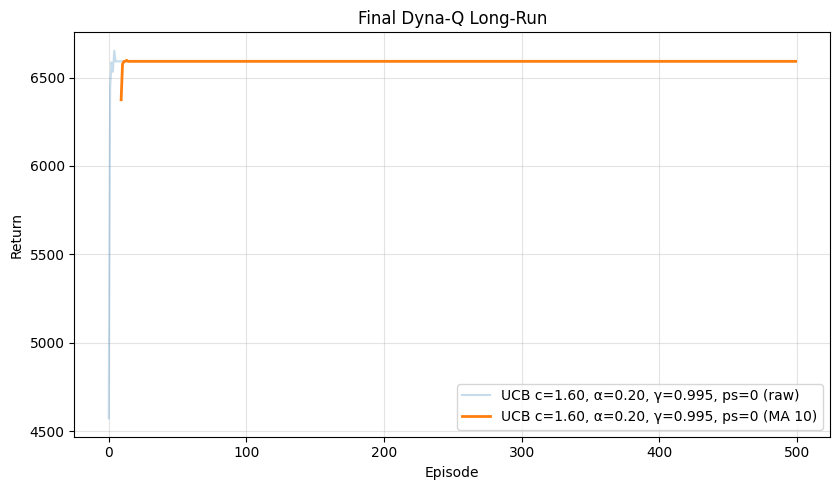

Saved learning curve to: figs/final_longrun_c1.60_a0.20_ps0_g0.995.png
Greedy evaluation (10 episodes): mean return = 6591.08


In [31]:
# === FINAL DYNA-Q TRAINING (Pinned config, save + evaluate) ===

# 1) Pin hyperparameters explicitly (avoid fallback surprises)
BEST_C  = float(globals().get("best_c", 2.0))   # set to float(best_c) if you already computed it; else 2.0
BEST_A  = float(globals().get("best_a", 0.10))
BEST_PS = int(globals().get("best_ps", 15))
BEST_G  = float(globals().get("best_g", 0.99))
LONG_EPISODES = 500
SEED = 4242

print("Final config:")
print(f"  UCB c       = {BEST_C}")
print(f"  alpha (lr)  = {BEST_A}")
print(f"  planning    = {BEST_PS}")
print(f"  gamma       = {BEST_G}")
print(f"  episodes    = {LONG_EPISODES}\n")

# 2) Train
Q_final, rets_final = train_dyna_q_explore(
    episodes=LONG_EPISODES,
    alpha=BEST_A,
    gamma=BEST_G,
    planning_steps=BEST_PS,
    strategy=Explore.UCB,
    ucb_c=BEST_C,
    eval_every=50,
    best_path=f"saved_models/final_ucb_longrun_c{BEST_C:.2f}_a{BEST_A:.2f}_ps{BEST_PS}_g{BEST_G:.3f}.json",
    seed=SEED,
)
print("✅ Training finished")

# 3) Save final Q-table with descriptive name
import os, json
os.makedirs("saved_models", exist_ok=True)
final_q_simple = "saved_models/dyna_q_final_best.json"
save_q(Q_final, final_q_simple)
print("Saved simplified Q-table to:", final_q_simple)

# 4) Plot and save the learning curve
import numpy as np, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)

def plot_with_ma(arr, label, w=10, alpha_line=0.25):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=alpha_line, label=f"{label} (raw)")
        plt.plot(x, mov, label=f"{label} (MA {w})", linewidth=2.0)
    else:
        plt.plot(arr, label=label, linewidth=2.0)

plt.figure(figsize=(8.5,5))
plot_with_ma(rets_final, f"UCB c={BEST_C:.2f}, α={BEST_A:.2f}, γ={BEST_G:.3f}, ps={BEST_PS}")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Final Dyna-Q Long-Run")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
curve_path = f"figs/final_longrun_c{BEST_C:.2f}_a{BEST_A:.2f}_ps{BEST_PS}_g{BEST_G:.3f}.png"
plt.savefig(curve_path, dpi=180)
plt.show()
print("Saved learning curve to:", curve_path)

# 5) Quick greedy evaluation (10 episodes, single-seed sweep)
greedy_mean = evaluate_greedy(Q_final, episodes=10, seed=777)
print(f"Greedy evaluation (10 episodes): mean return = {greedy_mean:.2f}")


# Quick sanity checks

# 1. Compare to baseline

In [32]:
rand_mean, rand_std = eval_random_masked(episodes=20, seed=777)
dq_mean = evaluate_greedy(Q_final if 'Q_final' in globals() else Q, episodes=20, seed=777)
print(f"Random: {rand_mean:.2f} ± {rand_std:.2f} | Dyna-Q: {dq_mean:.2f}")


Random: -3531.05 ± 1234.70 | Dyna-Q: 6591.08


# 2. See what actions the trained policy actually uses

In [34]:
from collections import Counter
def greedy_action_hist(Q, episodes=5, seed=999):
    hist = Counter()
    for k in range(episodes):
        env = LifeStyleEnv()
        obs, info = env.reset(seed=seed+k)
        s = state_key(obs); done=False
        while not done:
            mask = get_valid_mask(env); idx = np.where(mask)[0]
            a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0
            hist[a] += 1
            obs2, r, term, trunc, _ = env.step(a)
            s, done = state_key(obs2), bool(term or trunc)
        env.close()
    return hist

# === Add: quick skip ratio diagnostic ===
H = greedy_action_hist(Q_final if 'Q_final' in globals() else Q, episodes=5, seed=999)
total = sum(H.values())
skip_ratio = H.get(8, 0) / max(total, 1)
print(f"Skip ratio = {skip_ratio:.2%}  (counts = {dict(sorted(H.items()))})")



Skip ratio = 62.50%  (counts = {0: 1905, 1: 485, 3: 955, 4: 5, 5: 480, 6: 15, 7: 475, 8: 7200})


# Action distribution bar chart 

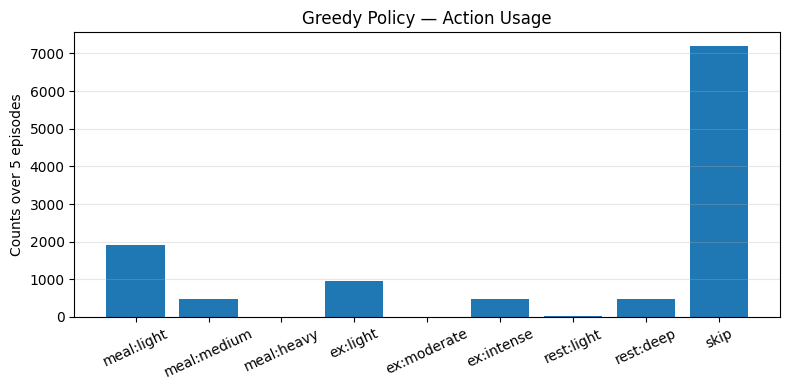

In [35]:
import matplotlib.pyplot as plt
labels = [
    "meal:light","meal:medium","meal:heavy",
    "ex:light","ex:moderate","ex:intense",
    "rest:light","rest:deep","skip"
]

H = greedy_action_hist(Q_final if 'Q_final' in globals() else Q, episodes=5, seed=999)
counts = [H.get(i,0) for i in range(9)]

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xticks(rotation=25)
plt.ylabel("Counts over 5 episodes")
plt.title("Greedy Policy — Action Usage")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Best Dyna-Q Model Daily Plan (Tabular Results)

In [36]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [37]:
from tabulate import tabulate

# --- Load your best Q-table ---
best_q_path = "saved_models/dyna_q_final_best.json"
Q_best = load_q(best_q_path)

def run_best_model_episode_ascii(Q, seed: int = 123):
    env = LifeStyleEnv()
    obs, info = env.reset(seed=seed)
    s = state_key(obs)
    done = False
    rows = []

    while not done:
        # greedy action
        mask = get_valid_mask(env)
        idx = np.where(mask)[0]
        a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0

        # env step
        obs2, r, term, trunc, info = env.step(a)

        # log row
        rows.append([
            int(obs.get("day_of_episode", 0)),
            int(obs["current_timeslot"]),
            ACTION_NAME.get(a, str(a)),
            env.daily_schedule[obs["current_timeslot"]-1] if hasattr(env, "daily_schedule") else "",
            f"{float(obs['current_bmi'][0]):.2f}",
            f"{float(obs['current_stress_level'][0]):.2f}",
            f"{float(obs['current_energy_level'][0]):.2f}",
            f"{float(obs['current_hunger_level'][0]):.2f}",
            f"{float(obs['daily_calories_intake']):.2f}",
            f"{float(obs['daily_calories_burned']):.2f}",
            f"{float(r):.2f}"
        ])

        s, obs, done = state_key(obs2), obs2, bool(term or trunc)

    env.close()
    # headers same as your screenshot
    headers = ["Day","Timeslot","Action","Event","BMI","Stress","Energy","Hunger",
               "Cal. Intake","Cal. Burned","Reward"]
    return tabulate(rows, headers=headers, tablefmt="pretty")

# --- Run and print ---
table_str = run_best_model_episode_ascii(Q_best, seed=999)
print("Starting Final Evaluation...\n")
print(table_str)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7256\1498016475.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(obs.get("day_of_episode", 0)),
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7256\1498016475.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_intake']):.2f}",
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7256\1498016475.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_burned']):.2f}",


Starting Final Evaluation...

+-----+----------+--------------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
| Day | Timeslot |       Action       | Event  |  BMI  | Stress | Energy | Hunger | Cal. Intake | Cal. Burned | Reward |
+-----+----------+--------------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
|  0  |    0     |        skip        | sleep  | 24.22 | 50.00  | 50.00  | 50.00  |    0.00     |    0.00     |  0.42  |
|  0  |    1     |        skip        | sleep  | 24.22 | 46.00  | 54.00  | 48.00  |    0.00     |    66.15    |  1.04  |
|  0  |    2     |        skip        | sleep  | 24.22 | 42.00  | 58.00  | 46.00  |    0.00     |   132.30    |  1.63  |
|  0  |    3     |        skip        | sleep  | 24.22 | 38.00  | 62.00  | 44.00  |    0.00     |   198.45    |  2.20  |
|  0  |    4     |        skip        | sleep  | 24.22 | 34.00  | 66.00  | 42.00  |    0.00     |   264.60    |  2.75  |
| 